### load all the libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cftime

## nb: getting nc_time_axis and esmlab to load on cheyenne required following the instructions under the heading "Creating your own clone of the NCAR Package Library" here: https://www2.cisl.ucar.edu/resources/python-–-ncar-package-library
## which thus meant: ncar_pylib -c 20190627 /glade/work/$USER/my_npl_clone
## ncar_pylib -c 20190627 /glade/work/$USER/my_npl_clone
## and subsequently
## ncar_pylib my_npl_clone
## pip install nc-time-axis
## pip install esmlab

xr.__version__

'0.15.1'

### define a function to go from monthly to annual values

In [2]:
def monthly_to_annual_xarray(array):
    mon_day  = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

### get a bunch of CPUs for running parallel processes

In [3]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=32,
                     processes=32, memory="108GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(32)
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.10.19:38713,Cluster Workers: 0 Cores: 0 Memory: 0 B


### where are all the relevant files?

In [5]:
#casename = 'fates_clm50_global_4x5_historicaltransient_nofire_2e3f469f_5e6fa21f'
casename = 'fates_clm50_global_4x5_historicaltransient_2e3f469f_2905a9ba'

datadir = '/glade/scratch/charlie/archive/'+casename+'/lnd/hist/'

paths = sorted(glob.glob(datadir+casename+'.clm2.h0.*.nc'))

landuse_filename = '/glade/u/home/charlie/scratch/landuse.timeseries_4x5_hist_16pfts_Irrig_CMIP6_simyr1850-2015_c190214_cdkmod_areaharvest_c200622.nc'

surfdata_filename = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_4x5_hist_16pfts_Irrig_CMIP6_simyr1850_c190214.nc'

In [6]:
data_vars =['SECONDARY_FOREST_FRACTION',
            'PATCH_AREA_BY_AGE',
            'PFTcanopycrownarea',
            'SECONDARY_AREA_PATCH_AGE_DIST',
            'SECONDARY_AREA_AGE_ANTHRO_DIST',
            'NPLANT_SCLS',
            'ED_biomass',
            'area',
            'WOOD_PRODUCT',
            'GPP',
            'NPP',
            'DISTURBANCE_RATE_P2S',
            'DISTURBANCE_RATE_LOGGING']
def preprocess(ds):
    '''specify a smaller set of data_vars'''
    return ds[data_vars]

### load the data and figure out the dimensions

In [7]:
%%time 
data_in=xr.open_mfdataset(paths,combine='by_coords',decode_times=False,
                     preprocess=preprocess,parallel=True)
time_vector = cftime.num2date(data_in['time'].values-16,units=data_in['time'].attrs['units'],
                calendar=data_in['time'].attrs['calendar'])
data_in['time']=xr.DataArray(time_vector,dims='time',attrs=data_in['time'].attrs)

CPU times: user 33.3 s, sys: 1.25 s, total: 34.6 s
Wall time: 1min 20s


In [8]:
landuse_file = xr.open_dataset(landuse_filename)
surfdata_file = xr.open_dataset(surfdata_filename)
ntim = len(data_in.variables['time'])
IM = len(data_in.variables['lon'])
JM = len(data_in.variables['lat'])

### plot secondary forest fraction at end of run

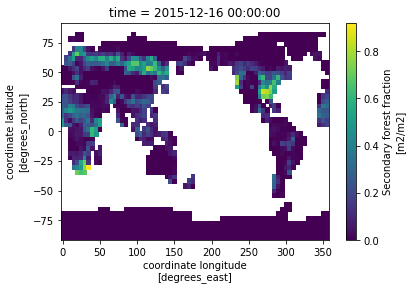

In [9]:
data_in.SECONDARY_FOREST_FRACTION.isel(time=ntim-1).plot()

### plot secondary forest fraction zonal mean over time

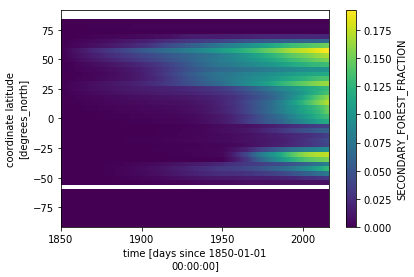

In [10]:
data_in.SECONDARY_FOREST_FRACTION.mean(dim='lon').plot(x='time', y='lat')

### plot timeseries of secondary forest area in million square km

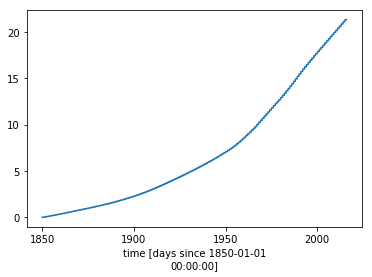

In [11]:
(data_in.area * data_in.SECONDARY_FOREST_FRACTION * 1e-6).sum(dim='lat').sum(dim='lon').plot()

### plot accumated logged area in million square km from forcing dataset

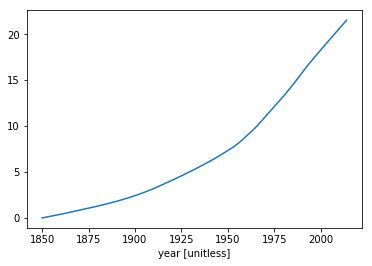

In [12]:
## need to normalize this by the fraction of a gridcell that FATES occupies.  
### two options of how to do this:

#option 1, use surface data file variables to reconstruct
#frac_fates = 1. - (surfdata_file.PCT_WETLAND + surfdata_file.PCT_GLACIER + surfdata_file.PCT_LAKE + surfdata_file.PCT_URBAN.sum(dim='numurbl')) * 1.e-2

# option 2, diagnose it from the FATES history file itself.  one way to do so is that the sum of PATCH_AREA_BY_AGE must equal 1, so we can use that to infer the FATES fraction
frac_fates = data_in.PATCH_AREA_BY_AGE.sum(dim='fates_levage').isel(time=0).values

primary_harvest_input = (landuse_file.HARVEST_VH1 + landuse_file.HARVEST_VH2) * landuse_file.AREA * 1e-6 * frac_fates
primary_harvest_input.sum(dim='lsmlon').sum(dim='lsmlat').cumsum(dim='time').isel(time=slice(0,int(ntim/12)-1)).plot()

### and also plot the rate of primary to secondary forest disturbance

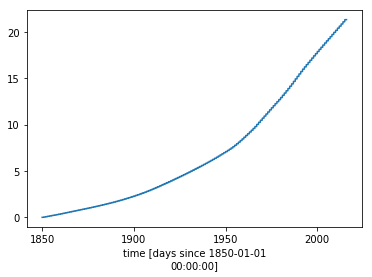

In [13]:
(31. * data_in.area * data_in.DISTURBANCE_RATE_P2S * 1e-6).sum(dim='lat').sum(dim='lon').cumsum(dim='time').plot()

### plot the rate of secondary forest logging disturbance (as the difference of all logging minus the rate of primary to secondary conversion)

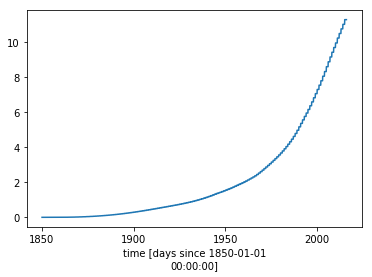

In [14]:
(31. * data_in.area * (data_in.DISTURBANCE_RATE_LOGGING - data_in.DISTURBANCE_RATE_P2S) * 1e-6).sum(dim='lat').sum(dim='lon').cumsum(dim='time').plot()

### and compare to the rate of harvest of all secondary three land types from the forcing data.  N.B., based on a bug that I have identified in the version of the code that ran this experiment, I'd expect it to get the wrong answer for this right now (which it does)

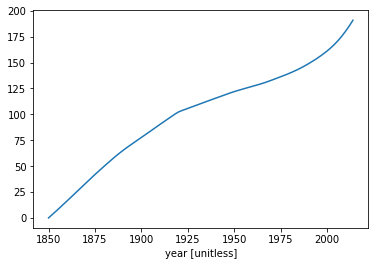

In [15]:
secondary_harvest_input = (landuse_file.HARVEST_SH1 + landuse_file.HARVEST_SH2 + landuse_file.HARVEST_SH3) * landuse_file.AREA * 1e-6 * frac_fates
secondary_harvest_input.sum(dim='lsmlon').sum(dim='lsmlat').cumsum(dim='time').isel(time=slice(0,int(ntim/12)-1)).plot()

In [16]:
### check to see if the fates gridcell fraction is correct.
## skipping this for now as I'm just using the other data

#plt.plot(frac_fates.values.flatten(), data_in.PATCH_AREA_BY_AGE.sum(dim='fates_levage').isel(time=0).values.flatten(), '.') 
#plt.xlabel('land surface file fraction')
#plt.ylabel('fates history file fraction')

### plot canopy coverage of each PFT at start of run

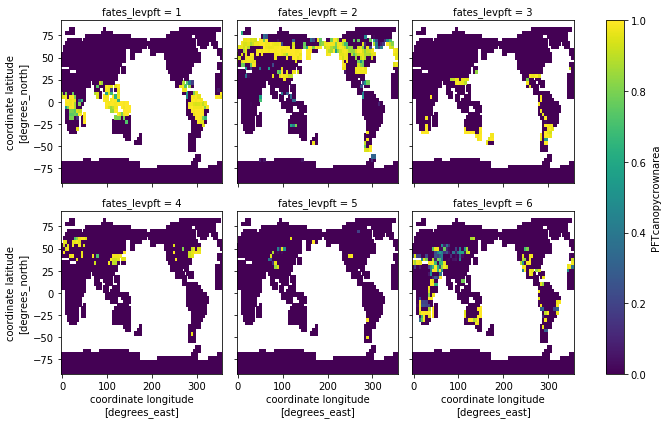

In [17]:
(data_in.PFTcanopycrownarea.isel(time=0)*1e-4).plot(x='lon',y='lat',col='fates_levpft', col_wrap=3)

### plot canopy coverage of each PFT at end of run

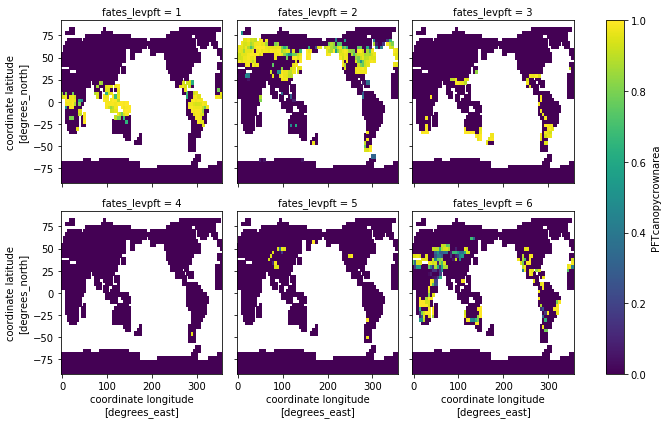

In [18]:
(data_in.PFTcanopycrownarea.isel(time=ntim-1)*1e-4).plot(x='lon',y='lat',col='fates_levpft', col_wrap=3)

### plot the change in globally-averaged patch age distributions over time

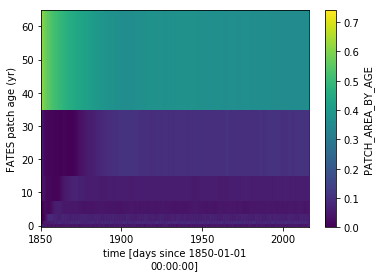

In [19]:
data_in.PATCH_AREA_BY_AGE.mean(dim='lon').mean(dim='lat').plot(x='time', y='fates_levage')

### plot age of all patch area since all types of disturbance, at start of simulation

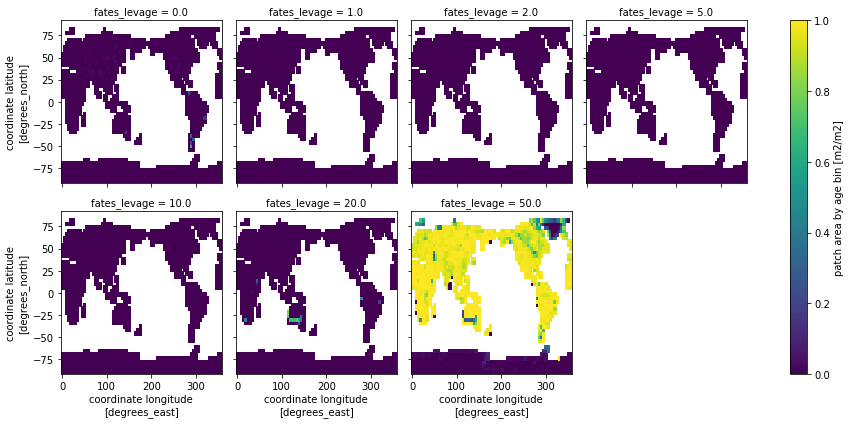

In [20]:
data_in.PATCH_AREA_BY_AGE.isel(time=0).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### plot age of all patch area since all types of disturbance, at end of simulation

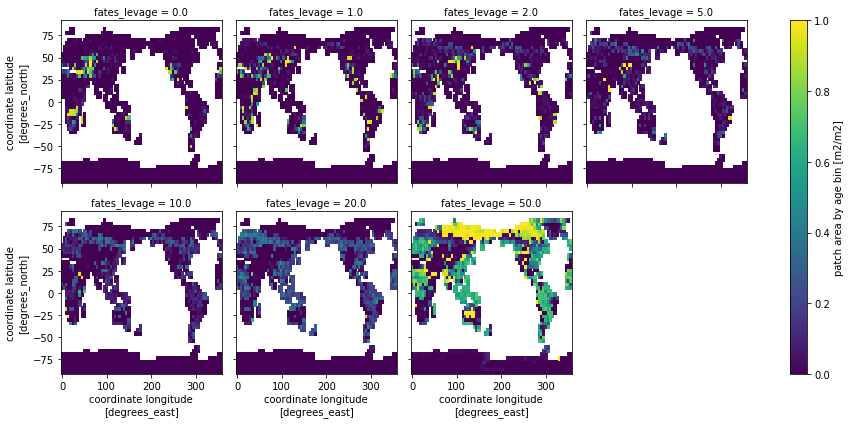

In [21]:
data_in.PATCH_AREA_BY_AGE.isel(time=ntim-1).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### plot age of secondary patch area since all types of disturbance.  normalize by total secondary patch area

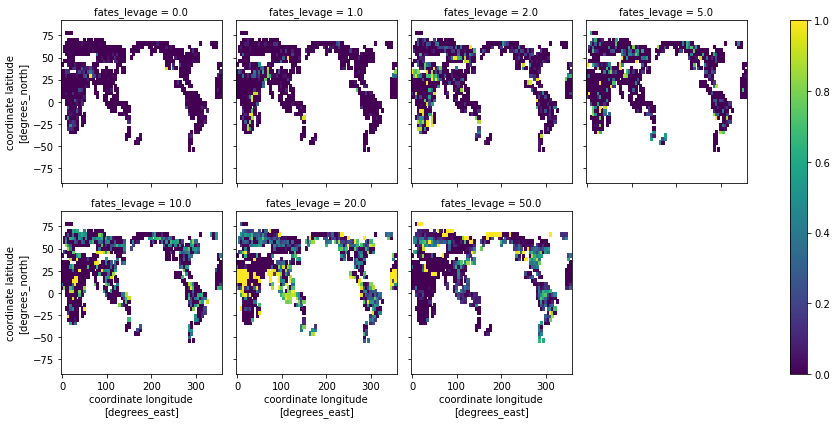

In [22]:
(data_in.SECONDARY_AREA_PATCH_AGE_DIST.isel(time=ntim-1)/data_in.SECONDARY_FOREST_FRACTION.isel(time=ntim-1)).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### plot age of secondary patch area since anthropogenic disturbance.  normalize by total secondary patch area.  This is affected by a bug which has subsequently been fixed.

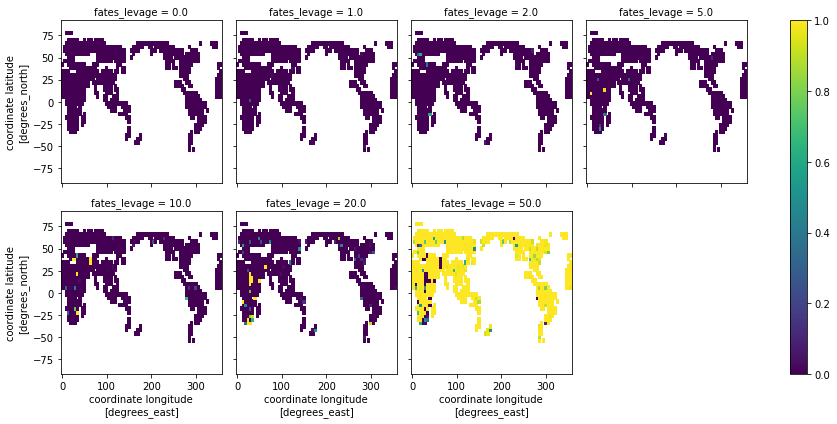

In [23]:
(data_in.SECONDARY_AREA_AGE_ANTHRO_DIST.isel(time=ntim-1)/data_in.SECONDARY_FOREST_FRACTION.isel(time=ntim-1)).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### snapshot of secondary forest age distribution in 1900

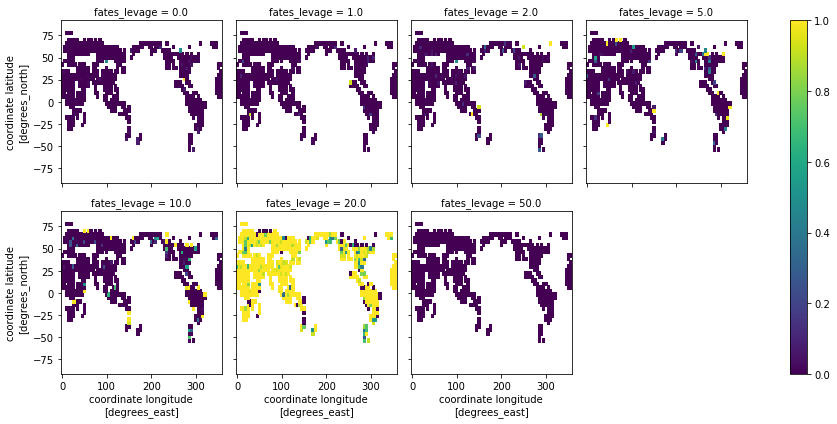

In [24]:
jan1900 = np.logical_and(data_in['time.year']==1900,data_in['time.month']==1)
(data_in.SECONDARY_AREA_AGE_ANTHRO_DIST.sel(time=jan1900)/data_in.SECONDARY_FOREST_FRACTION.sel(time=jan1900)).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### snapshot of secondary forest age distribution in 1950

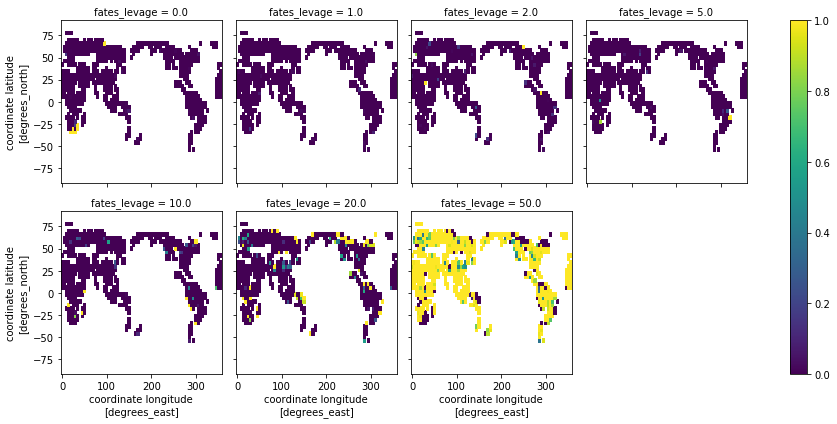

In [25]:
jan1950 = np.logical_and(data_in['time.year']==1950,data_in['time.month']==1)
(data_in.SECONDARY_AREA_AGE_ANTHRO_DIST.sel(time=jan1950)/data_in.SECONDARY_FOREST_FRACTION.sel(time=jan1950)).plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### plot globally-averaged tree size distributions changes over time

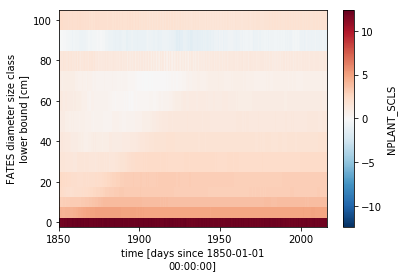

In [26]:
np.log(data_in.NPLANT_SCLS.mean(dim='lon').mean(dim='lat')).plot(x='time', y='fates_levscls')

### global biomass map at start of run

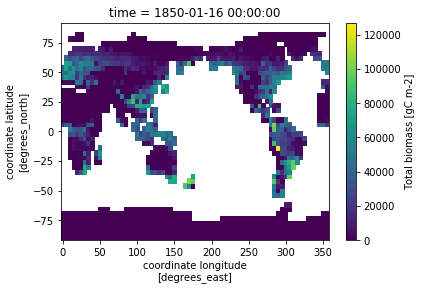

In [27]:
data_in.ED_biomass.isel(time=0).plot()

### zonal-mean biomass over time

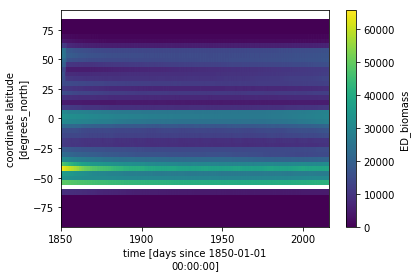

In [28]:
data_in.ED_biomass.mean(dim='lon').plot(x='time', y='lat')

### global integral of biomass over time

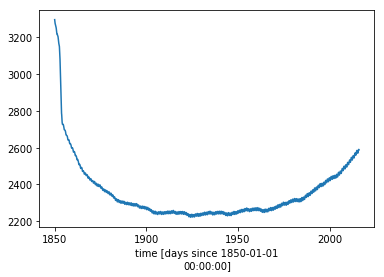

In [29]:
(data_in.area * data_in.ED_biomass * 1e6 * 1e-15).sum(dim='lon').sum(dim='lat').plot(x='time')

### plot timeseries of logged wood in Pg C

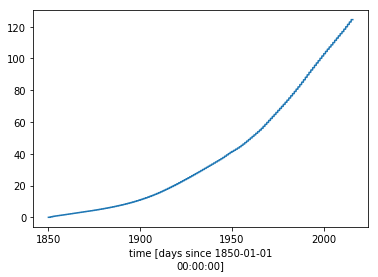

In [30]:
(data_in.area * data_in.WOOD_PRODUCT * 1e6*1e-15).sum(dim='lat').sum(dim='lon').plot()

### global integral of GPP over time

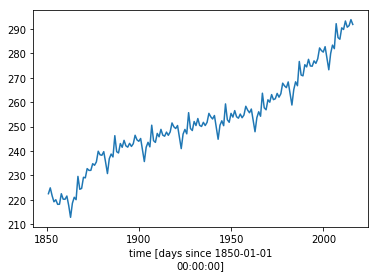

In [31]:
monthly_to_annual_xarray((data_in.area * data_in.GPP * 86400*365*1e-15*1e6).sum(dim='lon').sum(dim='lat').compute()).plot(x='time')

### global integral of NPP over time

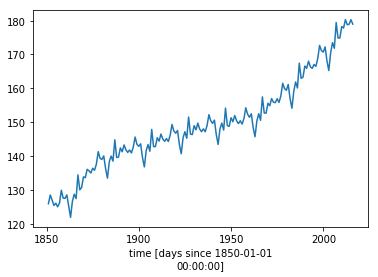

In [32]:
monthly_to_annual_xarray((data_in.area * data_in.NPP * 86400*365*1e-15*1e6).sum(dim='lon').sum(dim='lat').compute()).plot(x='time')